# Springboard--DSC Program

# Capstone Project 2 - Water Analytics 
# Milestone Report
### by Ellen A. Savoye

# Introduction

Water is an important part of everyday life. It’s easy to take the seemingly endless supply for granted. However, the water supply isn’t endless. To sustain our usage, water supply companies need to be able to forecast the amount of water in a given body of water under their purview to handle user consumption. These bodies of water could be a water spring, a lake, a river, or an aquifer. Each is affected by the changing of the seasons. Typically, bodies of water are replenished in the cooler seasons (autumn, winter) while warmer months (spring, summer) have a decrease in water level. Regardless of the season, it is important to be able to predict water availability, in terms of level or flow. Can a model be developed to predict water availability?


Acea Group, an Italian multi-utility operator, is invested in finding an answer. The company manages and develops water and electricity networks and environmental services. Acea is the foremost Italian operator in the water services sector supplying 9 million inhabitants in Lazio, Tuscany, Umbria, Molise, and Campania.

# Data

The data used for this project is provided by Acea. It is publicly available at the following address: https://www.kaggle.com/c/acea-water-prediction/data. The data comes from Acea’s records. Each dataset, a CSV file, is independent of each other as the different water sources are all independent. My focus was on aquifers, of which there are 4. 
When delving into the data, I noticed only 2 variables overlapped between the 4 datasets: date and rainfall. In wanting to create a model for aquifers in general, I decided to focus on one Aquifer in particular; Petrignano. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import packages and data


In [ ]:
!pip install pmdarima

In [ ]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import pickle
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import math
from datetime import datetime, date 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile
import glob

from statsmodels.tsa.stattools import adfuller

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
import pmdarima as pm

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_2/Code/"
dst = "/content/drive/My Drive/DS-Capstone_2/Data/"

In [ ]:
# convert the 7 datasets to pickle
for filepath in glob.iglob(dst + '/Aquifer*.csv'):
    print(filepath)
    word = 'Aquifer'
    file_nm = filepath[filepath.find(word):]

    df = pd.read_csv(dst + file_nm)
    file_nm = file_nm[:file_nm.find('.csv')]
    with open(dst + file_nm + '.p', 'wb') as f:
        pickle.dump(df, f)

for filepath in glob.iglob(dst + '/Water_Spring*.csv'):
    # print(filepath)
    word = 'Water_Spring'
    file_nm = filepath[filepath.find(word):]

    df = pd.read_csv(dst + file_nm)
    file_nm = file_nm[:file_nm.find('.csv')]
    with open(dst + file_nm + '.p', 'wb') as f:
        pickle.dump(df, f)

/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Doganella.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Petrignano.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Luco.csv
/content/drive/My Drive/DS-Capstone_2/Data/Aquifer_Auser.csv


## Exploring Aquifer Petrignano

In [ ]:
# Looking at 1 dataset - aquifer petrignano
Aq_Pet_df = pd.read_pickle(dst + 'Aquifer_Petrignano.p')

In [ ]:
Aq_Pet_df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


**Features**

*   **Rainfall_Bastia_Umbra**: the quantity of rain falling (mm)
*   **Temperature**: the temperature (°C)
*   **Volume_C10_Petrignano**: the volume of water taken from the drinking water treatment plant (m^3)
*   **Hydrometry_Fiume_Chiascio_Petrignano**: the groundwater level (m)

**Targets**
*   **Depth_to_Groundwater_P24/Depth_to_Groundwater_P25**: groundwater level (m from the ground floor)

In [ ]:
Aq_Pet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [ ]:
Aq_Pet_df['Date'] = pd.to_datetime(Aq_Pet_df.Date, format = '%d/%m/%Y')

In [ ]:
Aq_Pet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 326.6 KB


In [ ]:
Aq_Pet_df.shape

(5223, 8)

In [ ]:
Aq_Pet_df['Year'], Aq_Pet_df['Month'] = Aq_Pet_df['Date'].dt.year, Aq_Pet_df['Date'].dt.month
Aq_Pet_df['Day'] = Aq_Pet_df['Date'].dt.day
Aq_Pet_df['Quarter'], Aq_Pet_df['Day_of_year'] = Aq_Pet_df['Date'].dt.quarter, pd.DatetimeIndex(Aq_Pet_df['Date']).dayofyear

In [ ]:
Aq_Pet_df.isnull().sum(axis = 0)

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
Year                                       0
Month                                      0
Day                                        0
Quarter                                    0
Day_of_year                                0
dtype: int64

In [ ]:
Aq_Pet_df.isnull().groupby([Aq_Pet_df['Year']]).sum()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,Year,Month,Day,Quarter,Day_of_year
Year,,,,,,,,,,,,,
2006,0,293,3,0,293,293,197,293,0,0,0,0,0
2007,0,365,2,2,365,365,0,365,0,0,0,0,0
2008,0,366,11,10,366,366,0,366,0,0,0,0,0
2009,0,0,0,0,0,0,0,0,0,0,0,0,0
2010,0,0,0,0,0,0,0,0,0,0,0,0,0
2011,0,0,0,0,0,0,0,0,0,0,0,0,0
2012,0,0,7,7,0,0,0,0,0,0,0,0,0
2013,0,0,21,0,0,0,0,0,0,0,0,0,0
2014,0,0,0,9,0,0,0,0,0,0,0,0,0


Within this aquifer, the date is captured daily. However, I noticed that data coverage before 2009 was spotty at best. Given the intent to do a time series analysis, I chose to remove all records before January 1, 2009; keeping years 2009 to 2020. 


In [ ]:
# delete old rows with NA in feature to forecast 
nadate = dt.datetime(2008, 12, 31)
# print(nadate)
Aq_Pet_df = Aq_Pet_df[Aq_Pet_df.Date > nadate].reset_index(drop=True)

In [ ]:
Aq_Pet_df.isnull().sum()

Date                                     0
Rainfall_Bastia_Umbra                    0
Depth_to_Groundwater_P24                39
Depth_to_Groundwater_P25                27
Temperature_Bastia_Umbra                 0
Temperature_Petrignano                   0
Volume_C10_Petrignano                    1
Hydrometry_Fiume_Chiascio_Petrignano     0
Year                                     0
Month                                    0
Day                                      0
Quarter                                  0
Day_of_year                              0
dtype: int64

In looking at the missing values, we can see missing values in depth_to_groundwater_P24 (P24) and depth_to_groundwater_P25 (P25); two separate groundwater levels calculated by a piezometer. Because the depth-to-groundwater variables are the target variables, the missing values present an issue as the time series analysis requires consecutive values. This presented me with two options. I could either aggregate to a less granular level of data, week, month or year,  or I could try to fill in the missing values. As shown in the results below, there are 39 and 27 missing values for P24 and P25, respectively, over 11 years. I made a copy of my dataset to apply forward linear interpolation to approximate the missing values. 


In [ ]:
# fill in missing values using linear interpolation? or have that as part of extended analysis??
# Using linear interpolation will carry some of the characteristics of neighbouring values - can be seen as a best estimate for the new missing pieces
Aq_Pet_df_daily = Aq_Pet_df.copy()
Aq_Pet_df_daily = Aq_Pet_df_daily.interpolate(method ='linear', limit_direction ='forward')

In [ ]:
Aq_Pet_df_daily.rename(columns = {'Rainfall_Bastia_Umbra':'Rainfall', 'Depth_to_Groundwater_P24':'DG_P24', 'Depth_to_Groundwater_P25':'DG_P25',
                              'Temperature_Bastia_Umbra':'Temp_BU', 'Temperature_Petrignano':'Temp_P', 'Volume_C10_Petrignano':'Volume',
                              'Hydrometry_Fiume_Chiascio_Petrignano':'Hydrometry'}, inplace = True) 

Aq_Pet_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4199 non-null   datetime64[ns]
 1   Rainfall     4199 non-null   float64       
 2   DG_P24       4199 non-null   float64       
 3   DG_P25       4199 non-null   float64       
 4   Temp_BU      4199 non-null   float64       
 5   Temp_P       4199 non-null   float64       
 6   Volume       4199 non-null   float64       
 7   Hydrometry   4199 non-null   float64       
 8   Year         4199 non-null   int64         
 9   Month        4199 non-null   int64         
 10  Day          4199 non-null   int64         
 11  Quarter      4199 non-null   int64         
 12  Day_of_year  4199 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 426.6 KB


A quick check showed no more NULL values and confirmed my data was in chronological order with a time interval of 1 day.

In [ ]:
Aq_Pet_df_daily = Aq_Pet_df_daily.sort_values(by='Date')

# Check time intervals
Aq_Pet_df_daily['Date_Delta'] = Aq_Pet_df_daily['Date'] - Aq_Pet_df_daily['Date'].shift(1)

In [ ]:
Aq_Pet_df_daily['Date_Delta'].sum(), Aq_Pet_df_daily['Date_Delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

Thinking I had covered all possible aspects of missing data, I graphed P24, P25 hydrometry, temperature, volume, and rainfall below. Immediately, the dip in 2015 temperature Petrignano values stands out as it overlays temperature Bastia Umbra. The distribution between the two temperature fields is nearly identical except for the span of 2015. A similar dip can be seen in Hydrometry. Given that these values did not show up as NA previously, I looked for zero values in all columns. There are a few in Volume and Temperature_Bastia_Umbra.

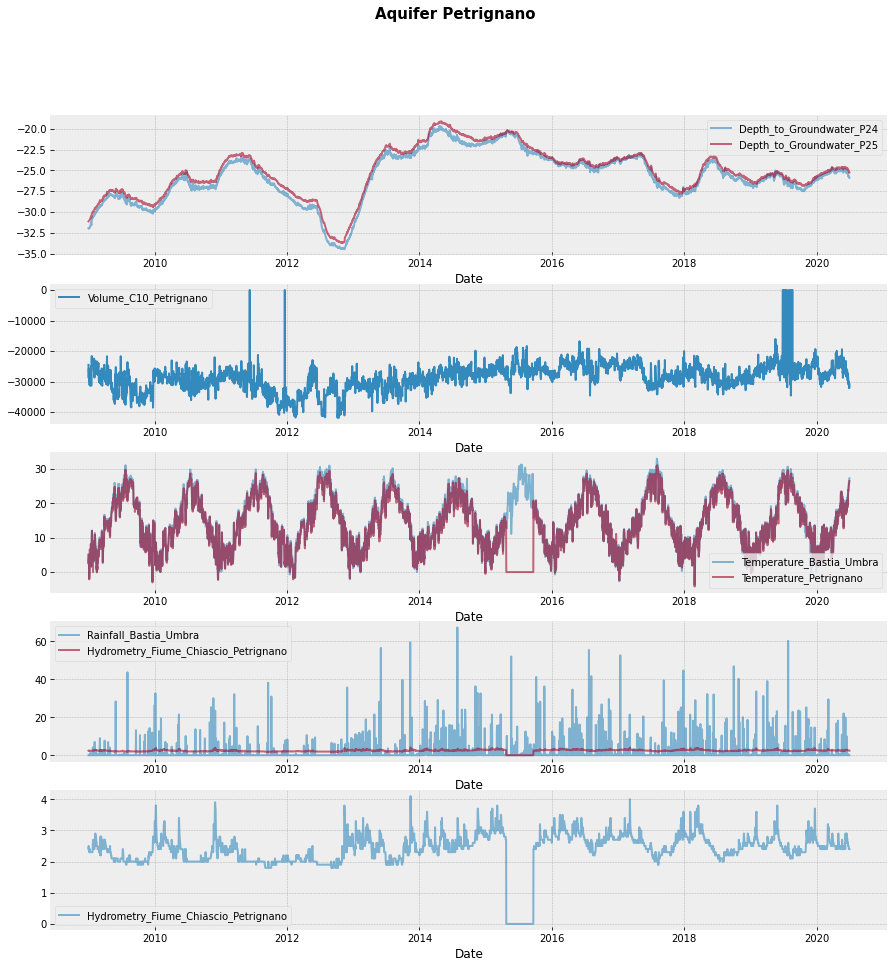

In [ ]:
fig, ax = plt.subplots(5, 1, figsize = (15, 15))
plt.suptitle('Aquifer Petrignano', size = 15, fontweight = 'bold')

# check overlay of depth to groundwater variables
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='DG_P24', ax=ax[0], label='Depth_to_Groundwater_P24', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='DG_P25', ax=ax[0], label='Depth_to_Groundwater_P25', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Volume', ax=ax[1], label='Volume_C10_Petrignano')

# check overlay of temperature variables
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Temp_BU', ax=ax[2], label='Temperature_Bastia_Umbra', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Temp_P', ax=ax[2], label='Temperature_Petrignano', alpha=0.6)

# overlay hydrometry and rainfall
# Hydrometry indicates the groundwater level, expressed in meters (m), detected by the hydrometric station
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Rainfall', ax=ax[3], label='Rainfall_Bastia_Umbra', alpha=0.6)
sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Hydrometry', ax=ax[3], label='Hydrometry_Fiume_Chiascio_Petrignano', alpha=0.6)

sns.lineplot(data=Aq_Pet_df_daily, x='Date', y='Hydrometry', ax=ax[4], label='Hydrometry_Fiume_Chiascio_Petrignano', alpha=0.6)

for i in ['top', 'right', 'bottom', 'left']:
  for y in [0, 1, 2, 3, 4]:
    ax[y].spines[i].set_visible(False)
    ax[y].set_ylabel('')

In [ ]:
(Aq_Pet_df_daily == 0).sum()

Date              0
Rainfall       3147
DG_P24            0
DG_P25            0
Temp_BU           7
Temp_P          153
Volume           25
Hydrometry      150
Year              0
Month             0
Day               0
Quarter           0
Day_of_year       0
Date_Delta        0
dtype: int64

In [ ]:
Aq_Pet_df_daily = Aq_Pet_df_daily.drop('Date_Delta', axis=1)

Both Temperature_Petrignano and Hydrometry show a significant amount of missing data, approximately 5 months worth of consecutive data. As there are over 10 years of data and the intent is to find the next consecutive day (or month) value, I'm comfortable in slimming the data down to 2016 and onward instead of trying to approximate 5 months worth of data. I believe this data set will still be robust enough to provide an excellent train/test set.

In [ ]:
# delete rows prior to 2016 
nadate = dt.datetime(2015, 12, 31)
# print(nadate)
Aq_Pet_df_daily = Aq_Pet_df_daily[Aq_Pet_df_daily.Date > nadate].reset_index(drop=True)

In [ ]:
(Aq_Pet_df_daily == 0).sum()

Date              0
Rainfall       1105
DG_P24            0
DG_P25            0
Temp_BU           4
Temp_P            0
Volume           22
Hydrometry        0
Year              0
Month             0
Day               0
Quarter           0
Day_of_year       0
dtype: int64

After dropping data before 2016, I checked for NULL, NAN, or 0 values. I found some missing values in temperature Bastia Umbra and volume. The zero values were converted to NAN before applying forward linear interpolation. Now that the data has been cleaned, it’s time to explore stationarity and seasonality.

In [ ]:
Aq_Pet_df_daily['Temp_BU'] = Aq_Pet_df_daily['Temp_BU'].replace(0, np.nan)
Aq_Pet_df_daily['Volume'] = Aq_Pet_df_daily['Volume'].replace(0, np.nan)

In [ ]:
Aq_Pet_df_daily['Temp_BU'] = Aq_Pet_df_daily['Temp_BU'].interpolate(method ='linear', limit_direction ='forward')
Aq_Pet_df_daily['Volume'] = Aq_Pet_df_daily['Volume'].interpolate(method ='linear', limit_direction ='forward')

# Exploring Stationarity and Seasonality

Some time-series models, such as ARIMA, assume the underlying data is stationary. Therefore, before applying any time-series models, stationarity needs to be checked. "[S]tationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time". Noticeable trends, seasonality, and changing levels are a few of the basic properties of non-stationary data. Looking at weekly temperature, we can see prominent seasonality. Volume clearly shows a noticeable trend and changing levels in the graph below.

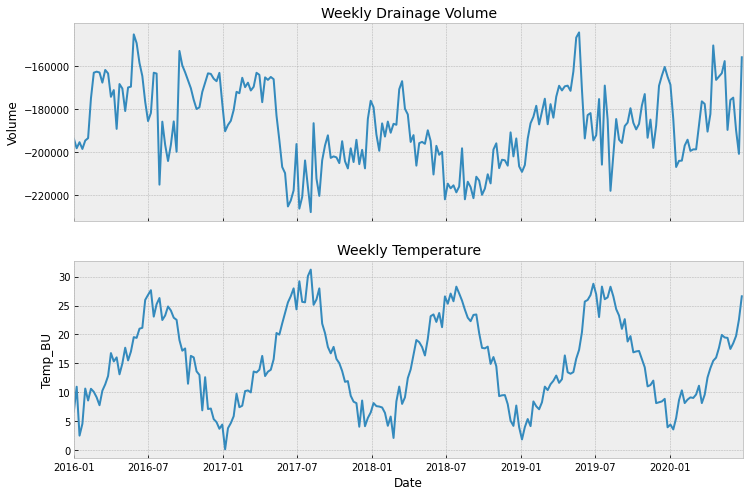

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,8))

resampled_aq = Aq_Pet_df_daily[['Date','Volume']].resample('7D', on='Date').sum().reset_index(drop=False)
sns.lineplot(resampled_aq['Date'], resampled_aq['Volume'], ax=ax[0])
ax[0].set_title('Weekly Drainage Volume', fontsize=14)

ax[0].set_xlim([date(2016, 1, 1), date(2020, 6, 30)])

resampled_aq = Aq_Pet_df_daily[['Date','Temp_BU']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_aq['Date'], resampled_aq['Temp_BU'], ax=ax[1])
ax[1].set_title('Weekly Temperature', fontsize=14)

for i in range(2):
    ax[i].set_xlim([date(2016, 1, 1), date(2020, 6, 30)])

Based on my observations, my initial take is the data is non-stationary. However, I used the Augmented Dickey-Fuller (ADF) test to try to confirm my observation. The test determines if the unit root is present in the series, which will determine if the series is stationary or not.
Null and Alternate hypothesis for ADF Test:

*   Null: the series has a unit root (value of a=1)
*   Alternate: the series has no unit root

If we fail to reject the null hypothesis, we can say the series is non-stationary.


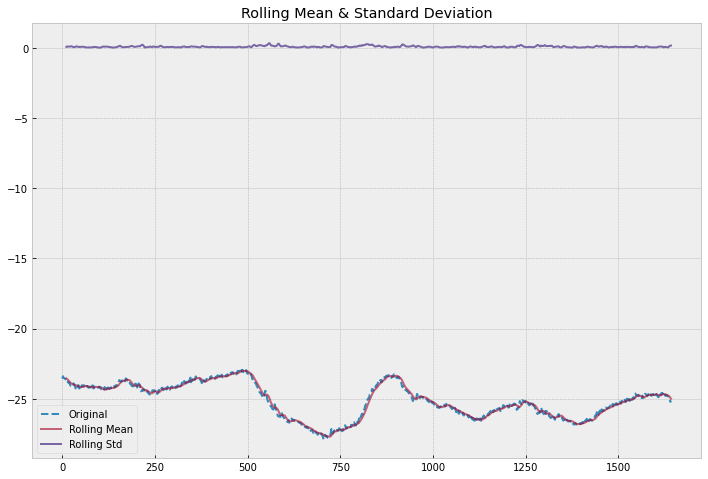

Results of Dickey-Fuller Test:
Test Statistic                   -2.447341
p-value                           0.128818
#Lags Used                       24.000000
Number of Observations Used    1618.000000
Critical Value (1%)              -3.434398
Critical Value (5%)              -2.863328
Critical Value (10%)             -2.567722
dtype: float64


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12,8))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25'], label='Original', linestyle='dashed')
mean = plt.plot(rolmean, label='Rolling Mean', alpha=0.6, linewidth=2)
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

**Test for stationarity** 

If the test statistic is greater than the critical value, we reject the null hypothesis which means the series is not stationary. If the test statistic is less than the critical value, we fail to reject the null hypothesis therefore the series is stationary.

Our test statistic is greater than the critical values. We reject the null hypothesis. Therefore, the series is not stationary.

Because time series, and ARIMA, requires data to be stationary, the data needs to be transformed. The data can be transformed using differencing or decomposition.
*   **Decomposition** – modeling both trend and seasonality and removing them from the model
*   **Differencing** – taking the differece with a particular time lag




We can break our time series up into pieces using decomposition. The pieces are as follows:

*   Seasonal - periodic up-and-downs in the data
*   Trend - pattern in the data spanning across seasonal periods
*   Cyclical - phenomena that happens across seasonal periods
*   Noise - random variation in the series

Seasonal, trend, and cyclical components can either be added or multiplied together.

*  Additive: y(t) = seasonal + trend + cyclical + noise
*  Multiplicative: y(t) = seasonal * trend * cyclical * noise

Using statsmodel, I'll be using the function seasonal_decompose() to piece apart my time series

In [ ]:
# seasonal decomposition
# Date, Rainfall, DG_P24, DG_P25, Temp_BU, Temp_P, Volume, Hydrometry
keep_columns =  [
    'Rainfall', 'Temp_BU', 'Volume', 
    'Hydrometry', 'DG_P25'
]

for k_col in keep_columns:
    decomp = seasonal_decompose(Aq_Pet_df_daily[k_col], period=52, model='additive', extrapolate_trend='freq')
    Aq_Pet_df_daily[f"{k_col}_trend"] = decomp.trend
    Aq_Pet_df_daily[f"{k_col}_seasonal"] = decomp.seasonal
    Aq_Pet_df_daily[f"{k_col}_residual"] = decomp.resid

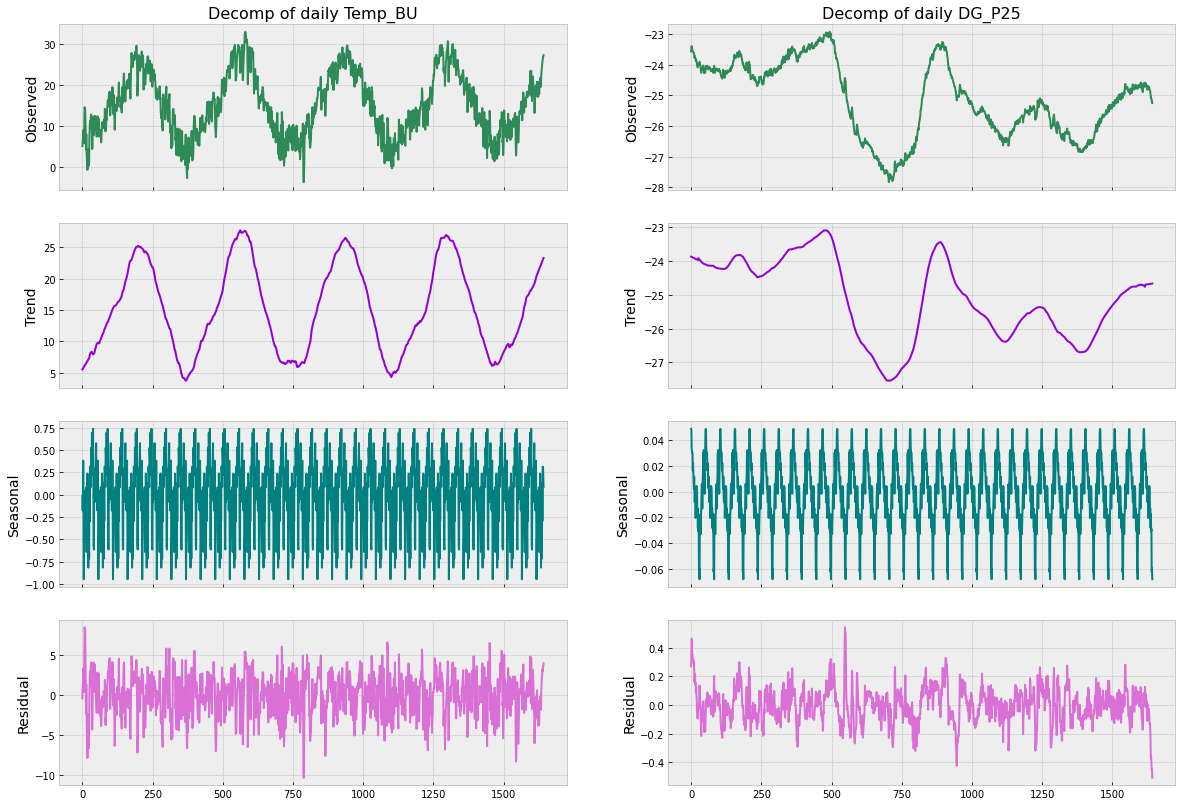

In [ ]:
# visualize the change
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20,14))

for i, column in enumerate(['Temp_BU', 'DG_P25']):
    
    res = seasonal_decompose(Aq_Pet_df_daily[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomp of daily {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color= 'seagreen')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color= 'darkviolet')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color= 'teal')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color= 'orchid')
    ax[3,i].set_ylabel('Residual', fontsize=14)


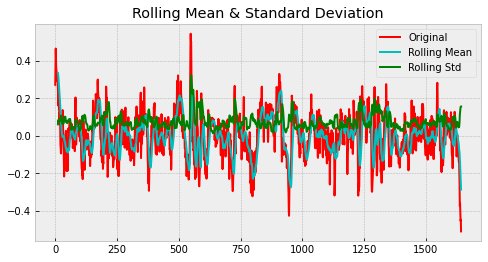

Results of Dickey-Fuller Test:
Test Statistic                -1.082606e+01
p-value                        1.755758e-19
#Lags Used                     2.000000e+00
Number of Observations Used    1.640000e+03
Critical Value (1%)           -3.434344e+00
Critical Value (5%)           -2.863304e+00
Critical Value (10%)          -2.567709e+00
dtype: float64


In [ ]:
# testing stationarity on residuals from decomposition

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(8,4))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25_residual'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25_residual'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25_residual'], label='Original', color='r')
mean = plt.plot(rolmean, label='Rolling Mean', linewidth=2, color='c')
std = plt.plot(rolstd, label = 'Rolling Std', color='g')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25_residual'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Looking at my results for the ADF test on the residuals, I can see that decomposing my time series, by removing trend and seasonality, did not create a stationary series. 

### Differencing

Because we didn’t achieve a stationary dataset using decomposition, differencing was the next attempt. In differencing, we take the difference of the observation at a particular record with that at the previous record based on x-number of days. To start, I tried first-order differencing, a single-day increment, to P25. With the application of differencing, it was necessary to apply the ADF test to determine if we achieved stationarity. The results of the test, seen below, show the test statistic is less than the critical values. I failed to reject the null hypothesis. Therefore, the series is now stationary.

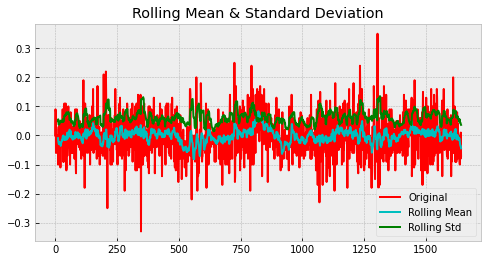

Results of Dickey-Fuller Test:
Test Statistic                   -4.787604
p-value                           0.000057
#Lags Used                       23.000000
Number of Observations Used    1619.000000
Critical Value (1%)              -3.434396
Critical Value (5%)              -2.863327
Critical Value (10%)             -2.567721
dtype: float64


In [ ]:
# first order differencing
Aq_diff = np.diff(Aq_Pet_df_daily['DG_P25'])

Aq_Pet_df_daily['DG_P25_f1'] = np.append([0], Aq_diff)

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(8,4))
#Determining rolling statistics
rolmean = Aq_Pet_df_daily['DG_P25_f1'].rolling(12).mean()
rolstd = Aq_Pet_df_daily['DG_P25_f1'].rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(Aq_Pet_df_daily['DG_P25_f1'], label='Original', color='r')
mean = plt.plot(rolmean, label='Rolling Mean', linewidth=2, color='c')
std = plt.plot(rolstd, label = 'Rolling Std', color='g')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(Aq_Pet_df_daily['DG_P25_f1'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

# Summary

Throughout the process, the data has been cleaned and processed for future use in a model. Next steps will be to put the, now stationary, data through my 3 models: baseline ARIMA, Auto-ARIMA, and Prophet models. The goal is to identify the best model for the client, provide recommendations, and future work/ehancements.